In [ ]:
#!usr/bin/env python
# encoding:utf-8
from __future__ import division
 
 
"""
__Author__:沂水寒城
功能： yaml 操作
"""
 
 
import sys
import yaml
 
 
def write2Yaml(data, save_path="test.yaml"):
    """
    存储yaml文件
    """
    with open(save_path, "w") as f:
        yaml.dump(data, f)
 
 
def loadData(data="config.yaml"):
    """
    加载yaml文件
    """
    with open(data, "r") as f:
        content = f.read()
    yamlData = yaml.load(content)
    print("yamlData_type: ", type(yamlData))
    print("yamlData: ", yamlData)
    return yamlData
 
 
if __name__ == "__main__":
    data = {
        "kind": "SeldonDeployment",
        "spec": {
            "name": "test-deployment",
            "predictors": [
                {
                    "graph": {
                        "endpoint": {"type": "REST"},
                        "type": "MODEL",
                        "name": "step_one",
                        "children": {
                            "endpoint": {"type": "REST"},
                            "type": "MODEL",
                            "name": "step_two",
                            "children": {
                                "endpoint": {"type": "REST"},
                                "type": "MODEL",
                                "name": "step_three",
                                "children": [],
                            },
                        },
                    },
                    "componentSpecs": [
                        {
                            "spec": {
                                "containers": [
                                    {
                                        "image": "seldonio/step_one:1.0",
                                        "name": "step_one",
                                    },
                                    {
                                        "image": "seldonio/step_two:1.0",
                                        "name": "step_two",
                                    },
                                    {
                                        "image": "seldonio/step_three:1.0",
                                        "name": "step_three",
                                    },
                                ]
                            }
                        }
                    ],
                    "name": "example",
                    "replicas": 1,
                }
            ],
        },
        "apiVersion": "machinelearning.seldon.io/v1alpha2",
        "metadata": {"name": "seldon-model"},
    }
 
 
    write2Yaml(data, save_path="test.yaml")
 
    yamlData = loadData(data="test.yaml")
 
 
    print(yamlData == data)
 

In [ ]:
import pandas as pd
import datetime

time_step = 1/60
start_dt = datetime.datetime.strptime("2021-05-25 00:01","%Y-%m-%d %H:%M")
end_dt = datetime.datetime.strptime("2021-06-29 00:00","%Y-%m-%d %H:%M")
time_delta = end_dt - start_dt
total_min = time_delta.days *24 *60 + time_delta.seconds // 60 + 1
step_per_min = 1/time_step/60
time_num = total_min *step_per_min
print(total_min)


dates = pd.date_range(start=start_dt,end=end_dt,freq='min')
date_list = [x.strftime("%H:%M") for x in dates]
indice_num = len(dates)//4
show_dates = date_list[::indice_num] + [date_list[-1]]


show_dates = [show_dates[i].split(" ")[-1] for i in range(4)]
print(show_dates)

timestamp = str(datetime.datetime.now()).split(".")[0].replace(" ", "T").replace("-","").replace(":","")
print(timestamp)

import os
p = os.path.split(os.path.realpath(__file__))[0]
print(p)

# 面源污染径流产生过程线模型

In [1]:
## 面源污染负荷估算主程序
import os
from datetime import datetime
import pandas as pd
import xlrd
import numpy as np

def get_month(begin,end):
    begin_year,end_year=begin.year,end.year
    begin_month,end_month=begin.month,end.month
    if begin_year==end_year:
        months=end_month-begin_month
    else:
        months=(end_year-begin_year)*12+end_month-begin_month
    return months + 1


""" 1. 读取Project文件"""
file_path = 'data/non_point_pollution/Project.xlsx'
io = pd.io.excel.ExcelFile(file_path)
timeseriesdata = pd.read_excel(io,sheet_name="TimeSeries").values
patchdata = pd.read_excel(io,sheet_name="Patch").values
pollutantdata = pd.read_excel(io,sheet_name="Pollutant").values
controlunitdata = pd.read_excel(io,sheet_name="ControlUnit").values
ludata = pd.read_excel(io,sheet_name="LandUse").values
usdata = pd.read_excel(io,sheet_name="UnderlyingSurface").values
io.close()

# 读取时间、降雨量、蒸发量数据
tlabel = [xlrd.xldate.xldate_as_datetime(t,0) 
          for t in timeseriesdata[:, 0]]
rain = timeseriesdata[:, 1]
evap = timeseriesdata[:, 2]

nhour = len(tlabel)
nday = int((tlabel[-1]-tlabel[0]).days) + 1
nmonth = get_month(tlabel[0],tlabel[-1])
nyear = 1

# 读取整个城区所有斑块的id数据
patchid = patchdata[:, 0]
patchstreet = patchdata[:, 1]
patchlu = patchdata[:, 2]
patchus = patchdata[:, 3]
patcharea = patchdata[:, 4]
N = len(patchid)

# 读取污染指标对应的id
pollutantid = pollutantdata[:, 0]
npl = len(pollutantid)

# 读取控制单元对应的街道和区的id
streetid = controlunitdata[:, 0]
streetdistrict = controlunitdata[:, 1]
ns = len(streetid)
nd = max(streetdistrict)

# 读取土地利用类型的id
luid = ludata[:, 0]
nlu = len(luid)

# 读取下垫面类型的id以及对应的最大初损、下渗率
usid = usdata[:, 0]
usloss = usdata[:, 2]
usinfil = usdata[:, 3]
nus = len(usid)

# 读取所有土地利用类型和下垫面类型对应的水质参数
P = {p:{"Bmax":None,
        "bt":None,
        "C1":None,
        "C2":None,
        "EMC":None,} 
     for p in range(npl)}
for p in range(npl):
    P[p]["Bmax"] = ludata[:, 2+p] ##ok<*SAGROW>
    P[p]["bt"] = ludata[:, 2+npl+p]
    P[p]["C1"] = usdata[:, 4+p]
    P[p]["C2"] = usdata[:, 4+npl+p]
    P[p]["EMC"] = usdata[:, 4+2*npl+p]


"""2. 单位面积的径流污染产生过程线模型"""
# 2.1 rainfall runoff process simulation
# 初始化
storage = np.zeros((nhour, nus))
runoff = np.zeros((nhour, nus))
storage[0,:] = usloss.T
B = np.zeros((nhour, nus*nlu*npl))
W = np.zeros((nhour, nus*nlu*npl))

# 每个时刻不同下垫面的剩余蓄水能力和径流量动态变化
for t in range(1, nhour):
    for u in range(nus):
        storage[t, u] = min(usloss[u], 
                            storage[t-1, u] - rain[t] + evap[t] + usinfil[u])
        if storage[t, u] < 0:
            # 当蓄水能力小于0时，产生径流
            runoff[t, u] = 0 - storage[t, u]
            storage[t, u] = 0

# 每个时刻各个土地利用类型、下垫面类型的每一种污染物含量动态变化
for t in range(1, nhour):
    for p in range(npl):
        for l in range(nlu):
            for u in range(nus):
                if P[p]["EMC"][u] == 0:
                    if rain[t] == 0:
                        B[t, p*nlu*nus + l*nus + u] = min(P[p]["Bmax"][l], 
                                                                  B[t-1, p*nlu*nus + l*nus + u] + P[p]["bt"][l])
                    else:
                        W[t, p*nlu*nus + l*nus + u] = P[p]["C1"][u] * runoff[t, u]**P[p]["C2"][u] \
                            * B[t-1, p*nlu*nus + l*nus + u]
                        B[t, p*nlu*nus + l*nus + u] = max(0, B[t-1, p*nlu*nus + l*nus + u] \
                            - W[t, p*nlu*nus + l*nus + u])
                else:
                    W[t, p*nlu*nus + l*nus + u] = runoff[t, u] * P[p]["EMC"][u]


## 3. 叠加分析
patchhourlyload = np.zeros((nhour, N*npl))
streethourlyload = np.zeros((nhour, ns*npl))
districthourlyload = np.zeros((nhour, nd*npl))
cityhourlyload = np.zeros((nhour, npl))
totalrunoff = 0 
totalload = np.zeros(npl)

# 遍历所有斑块，以获得不同尺度（斑块、街道、区、城市）每小时的各类污染物的负荷
for n in range(N):
    lu = patchlu[n] - 1 # TODO
    us = patchus[n] -1 # TODO
    # lu = patchlu[n]
    # us = patchus[n]
    totalrunoff += sum(runoff[:, us]) * patcharea[n]
    # 遍历污染指标
    for p in range(npl):
        patchhourlyload[:, n*npl+ p] = W[:,p*nlu*nus + lu*nus + us] * patcharea[n]
        streethourlyload[:, (patchstreet[n]-1)*npl+p] = \
            streethourlyload[:, (patchstreet[n]-1)*npl+p] + patchhourlyload[:, n*npl+ p]
        totalload[p] = totalload[p] + sum(patchhourlyload[:, n*npl+ p])

# 根据每小时的污染物负荷，计算出每天的负荷
patchdailyload = np.zeros((nday, N*npl))
streetdailyload = np.zeros((nday, ns*npl))
districtdailyload = np.zeros((nday, nd*npl))
citydailyload = np.zeros((nday, npl))
for d in range(nday):
    patchdailyload[d, :] = sum(patchhourlyload[d*24:(d+1)*24,:])
    streetdailyload[d, :] = sum(streethourlyload[d*24:(d+1)*24,:])

# 根据每天的污染物负荷，计算出总的负荷
streettotalload = np.zeros((ns, npl))
for s in range(ns):
    for p in range(npl):
        temp = sum(streetdailyload)
        # 计算街道年总负荷
        streettotalload[s, p] = temp[s*npl + p]
        # 计算城市日负荷
        citydailyload[:, p] = citydailyload[:, p] + streetdailyload[:, s*npl + p]

In [1]:
from datetime import datetime
"""4. 总体验证&生成报告"""
save_root = "results/block"
report_dir = "non_point_pollution"
save_dir = os.path.join(save_root,report_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)
timestamp = str(datetime.now()).split(".")[0].replace(" ", "T").replace("-","").replace(":","")
save_path = os.path.join(save_dir, "result_rpua_"+timestamp+".xlsx")    

# save
totalrunoff_np = np.zeros((1,1))
totalrunoff_np[0] = totalrunoff
totalrunoff = pd.DataFrame(totalrunoff_np)
totalload = pd.DataFrame(totalload)
runoff = pd.DataFrame(runoff)
W = pd.DataFrame(W)
streettotalload = pd.DataFrame(streettotalload)
citydailyload = pd.DataFrame(citydailyload)

writer = pd.ExcelWriter(save_path)
totalrunoff.to_excel(writer,sheet_name='Sheet1',startrow=1, startcol=1, index=False,header=False)
totalload.to_excel(writer,sheet_name='Sheet1',startrow=2, startcol=1, index=False,header=False)
runoff.to_excel(writer,sheet_name='单位面积径流过程线',startrow=1, startcol=1, index=False,header=False)
W.to_excel(writer,sheet_name='单位面积负荷过程线',startrow=3, startcol=1, index=False,header=False)
streettotalload.to_excel(writer,sheet_name='街道年总负荷分布',startrow=2, startcol=1, index=False,header=False)
citydailyload.to_excel(writer,sheet_name='城市日负荷过程线',startrow=2, startcol=1, index=False,header=False)
writer.save()

NameError: name 'np' is not defined

# 将天气数据从excel转化为txt

In [6]:
import pandas as pd
import numpy as np
import xlrd

file_path = 'data/non_point_pollution/rainfall.xlsx'
io = pd.io.excel.ExcelFile(file_path)

timeseriesdata = pd.read_excel(io).values
# tlabel = [xlrd.xldate.xldate_as_datetime(t,0)
#           for t in timeseriesdata[:, 0]]
rain = timeseriesdata[:, 1]
# evap = timeseriesdata[:, 2]

# data = timeseriesdata[:,:2]
# data = np.zeros((len(rain),3))
# data[:,0] = tlabel
# data[:,1] = rain
# data[:,2] = evap
save_path ="rainfall-20150112T10-20150112T23.txt"
np.savetxt(save_path,rain,delimiter=' ',fmt="%.2f")

In [1]:
import numpy as np
import os 

file_dir = "data/non_point_pollution"
weather_file_path ="rainfall-20150112T10-20150112T23.txt"
file_path = os.path.join(file_dir,weather_file_path)

data = np.loadtxt(file_path)
# rainfall = data[:, 0]  # 降雨量，mm/hr

# 画图

## 降雨量

In [3]:
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# matplotlib.use("Qt5Agg")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif']=['Microsoft Yahei'] # 设定字体为微软雅黑

class MyFigure(FigureCanvasQTAgg):
   def __init__(self,width=5,height=4,dpi = 100):
      # 1、创建一个绘制窗口Figure对象
      self.fig = Figure(figsize=(width,height),dpi=dpi,tight_layout=True)
      # 2、在父类中激活Figure窗口,同时继承父类属性
      super(MyFigure, self).__init__(self.fig)
 
   # 这里就是绘制图像、示例
   def plotSin(self,x,y):
      self.axes0 = self.fig.add_subplot(111)
      self.axes0.plot(x,y)

def get_xticklabels(start,end,num=6,freq='min'):
   print("freq: ",freq)
   dates = pd.date_range(start=start,end=end,freq=freq)
   date_list = [x.strftime("%Y-%m-%d %H:%M") for x in dates]
   print(date_list)
   show_dates = date_list[::len(dates)//num] + [date_list[-1]]
   
   xticks = list(range(0,len(dates),len(dates)//num)) + [len(dates)-1]
   xlabels = [show_dates[i] for i in range(len(show_dates))]
   
   return xticks, xlabels
 
def fig_rainfall(values, width,height, start_dt_str,end_dt_str, freq):
   F1 = MyFigure(width=width, height=height, dpi=150)
   F1.resize(width,height)
   F1.axes1 = F1.fig.add_subplot(111) 

   fs = 20
   xx_pred = range(len(values))

   F1.axes1.bar(xx_pred, values, width=1,fc='b')
   # plt.show()
   # F1.axes1.plot(xx_pred,values,color='r',lw=2,linestyle="--",label="模拟值")
   xticks, xlabels = get_xticklabels(start_dt_str,end_dt_str, freq=freq)

   # F1.axes1.legend(fontsize=fs-2)
   F1.axes1.set_xlabel(u"时间", fontsize=fs-2)
   F1.axes1.set_ylabel(u"降雨量 (mm/h)", fontsize=fs-5)
   F1.axes1.set_xticks(xticks)
   F1.axes1.set_xticklabels(labels=xlabels,rotation=90)
   # F1.axes1.set_yticklabels(fontsize=fs-2)
   F1.axes1.tick_params(axis='x',labelsize=fs-2)
   F1.axes1.tick_params(axis='y',labelsize=fs)    
   F1.axes1.grid(alpha=0.5,linestyle="-.")
   # F1.show()
   
file_dir = "data/non_point_pollution"
weather_file_path ="rainfall-20150112T10-20150112T23.txt"
file_path = os.path.join(file_dir,weather_file_path)

data = np.loadtxt(file_path)

fig_rainfall(values=data, width=520,height=360, 
             start_dt_str="2022-09-14T10",
             end_dt_str="2022-09-14T23", 
             freq="1H")


freq:  1H
['2022-09-14 10:00', '2022-09-14 11:00', '2022-09-14 12:00', '2022-09-14 13:00', '2022-09-14 14:00', '2022-09-14 15:00', '2022-09-14 16:00', '2022-09-14 17:00', '2022-09-14 18:00', '2022-09-14 19:00', '2022-09-14 20:00', '2022-09-14 21:00', '2022-09-14 22:00', '2022-09-14 23:00']


: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


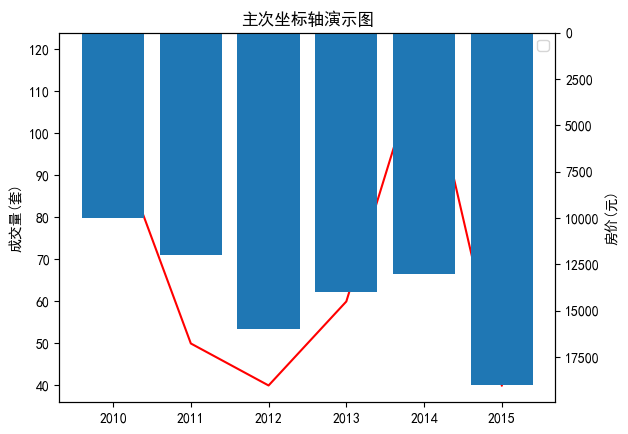

In [9]:

import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为微软雅黑

# 定义房价
price = [10000, 12000, 16000, 14000, 13000, 19000]
# 定义成交量
total = [100, 50, 40, 60, 120, 40]
# 定义年份
year = [2010, 2011, 2012, 2013, 2014, 2015]

fig, ax = plt.subplots(1, 1)
# 共享x轴，生成次坐标轴
ax_sub = ax.twinx()
# 绘图
ax.plot(year, total, 'r-', label='total')
ax_sub.bar(year, price)

# 翻转房价的坐标轴
ax_sub.invert_yaxis()

# 放置图例
plt.legend(loc=0)
# 设置主次y轴的title
ax_sub.set_ylabel('房价(元)')
ax.set_ylabel('成交量(套)')
# 设置x轴title
ax_sub.set_xlabel('年份')
# 设置图片title
ax_sub.set_title('主次坐标轴演示图')
plt.show()


In [2]:
from utils.algo.figure_function import *
import numpy as np

rain = np.random.normal(1,1,14)
rain_ = rain.reshape(-1,1)
runoff = np.concatenate((rain_ * 0.9, rain_*0.6),axis=1)
name_list=["斑块", "海绵"]
width,height = 1000,800
start_dt_str = "2022-9-21T10:09:59"
end_dt_str = "2022-9-21T23:09:59"
freq = "1H"

F = fig_rainfall_runoff(rain,runoff, name_list,width,height, start_dt_str,end_dt_str, freq)
F.show()

: 

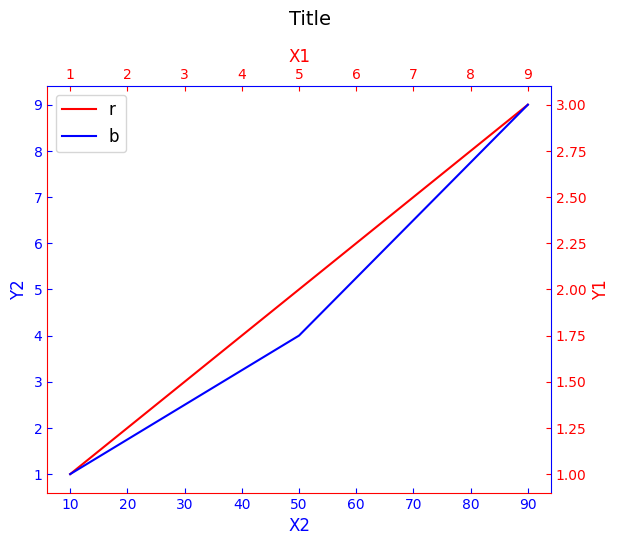

In [2]:
"""
使用plt，通过fig.add_subplot方式将两对坐标系叠加在一个fig上实现双X轴双Y轴效果。
所有调整均可完美实现，推荐该方式
"""
import matplotlib.pyplot as plt
import numpy as np
 
"""生成数据并设置绘图参数"""
x = np.arange(1, 12, 4)
y = np.arange(1, 4, 1)
x2=x*10
y2=y**2
# 设置两种绘图颜色
c1='r'
c2='b'
# 设置字体大小
fontsize=12
# 设置画布大小
width,height=16,14 # 单位为cm；因为保存图片时使用 bbox_inches = 'tight' 可能使图片尺寸略微放大，所以此处宽度设置得略小
# 设置刻度线在坐标轴内
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
"""绘图"""
lns=[] # 用于存储绘图句柄以合并图例的list
# 创建画布并设置大小
fig=plt.figure()
fig.set_size_inches(width/2.54, height/2.54) # 因为画布输入大小为厘米，此处需转换为英寸，所以除以2.54
# 通过 add_subplot 方式创建两个坐标轴，相当于在同一个子图上叠加了两对坐标系
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
# 绘制图1并将绘图句柄返回，以便添加合并图例
lns1=ax.plot(x,y,color=c1,label=c1)
lns=lns1
lns2=ax2.plot(x2,y2, color=c2,label=c2)
lns+=lns2
"""图形美化"""
# 调整第二对坐标轴的label和tick位置，以实现双X轴双Y轴效果
ax.xaxis.tick_top()
ax.yaxis.tick_right()
ax.xaxis.set_label_position('top')
ax.yaxis.set_label_position('right')

ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()
ax2.xaxis.set_label_position('bottom')
ax2.yaxis.set_label_position('left')
# 设置坐标轴标注
ax.set_xlabel("X1", color=c1,fontsize=fontsize)
ax.set_ylabel("Y1", color=c1,fontsize=fontsize)
ax2.set_xlabel('X2', color=c2,fontsize=fontsize)
ax2.set_ylabel('Y2', color=c2,fontsize=fontsize)
# 设置图表标题
fig.suptitle("Title",fontsize=fontsize+2)
# 设置坐标轴刻度颜色
ax.tick_params(axis='x', colors=c1)
ax.tick_params(axis='y', colors=c1)
ax2.tick_params(axis='x', colors=c2)
ax2.tick_params(axis='y', colors=c2)
# 设置坐标轴线颜色
ax.spines["left"].set_color("r") # 修改左侧颜色
ax.spines["right"].set_color("b") # 修改右侧颜色
ax.spines["top"].set_color("b") # 修改上边颜色
ax.spines["bottom"].set_color("r") # 修改下边颜色
# 添加图例
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0,fontsize=fontsize)
plt.tight_layout()
plt.show()

# 芝加哥雨型模型

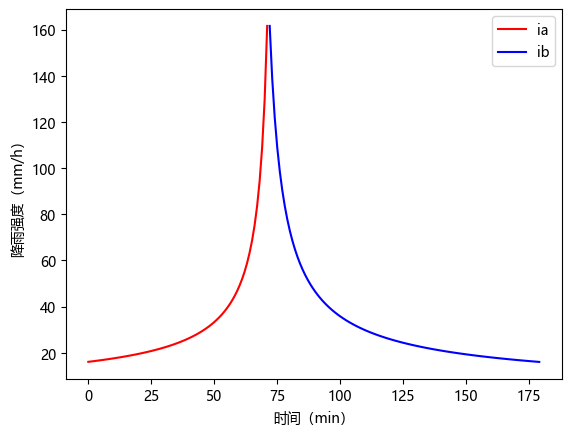

(3, 60)
[ 88662.23382736 209020.67102303  71512.46073155]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif']=['Microsoft Yahei'] # 设定字体为微软雅黑

A = 8.701 # 雨力参数
C = 0.594 # 雨力变动参数
b = 11.13 # 降雨历时修正参数
n = 0.555 # 衰减系数

r = 0.4 # 雨峰系数
P = 2 # 降雨重现期
T = 180 # 降雨历时

# 峰前、后降雨历时
Ta = int(T *r)
Tb = T - Ta
ta = np.arange(Ta)
tb = np.arange(Tb)

a =  A * (1+ C * np.log10(P))
ia = a * ( (1-n)*ta/r + b ) / (ta/r +b)**(1+n) *60
ib = a * ( (1-n)*tb/(1-r) + b ) / (tb/(1-r) + b) **(1+n) *60

ia = ia[::-1]
# x1 = range(Tb,T)
# x2 = range(Tb)
x1 = range(Ta)
x2 = range(Ta,T)
plt.plot(x1, ia,color="r",label="ia")
plt.plot(x2, ib,color="b",label="ib")
plt.legend()
plt.xlabel("时间（min）")
plt.ylabel("降雨强度（mm/h）")
plt.show()

rain = np.concatenate((ia,ib),axis=0)
remain = rain.shape[0] % 60
hour = rain.shape[0] // 60+1 if remain else rain.shape[0] // 60

rainHour = rain.reshape(hour,-1)
print(rainHour.shape)
print(rainHour.sum(axis=1)*60)

In [3]:
import pandas as pd

file_path = "utils/algo/non_point_pollution_params copy.xlsx"
io = pd.io.excel.ExcelFile(file_path)
# timeseriesdata = pd.read_excel(io,sheet_name="TimeSeries").values
# patchdata = pd.read_excel(io,sheet_name="Patch").values
pollutantdata = pd.read_excel(io,sheet_name="Pollutant").values
# controlunitdata = pd.read_excel(io,sheet_name="ControlUnit").values
ludata = pd.read_excel(io,sheet_name="LandUse")
usdata = pd.read_excel(io,sheet_name="UnderlyingSurface").values
io.close()
print(ludata.head(10))

   Id    土地利用类型       Bmax_SS     Bmax_COD    Bmax_TP     Bmax_TN  Bmax_NH3N  \
0   1      居住用地  20999.444444  6321.907810  21.285750  126.089090  12.254769   
1   2    行政办公用地   3435.507246  1292.637681  60.210319   53.332903   2.611630   
2   3    商业金融用地   3118.623188  2101.014493   8.001087   49.100362   6.727381   
3   4    文化娱乐用地  15745.483092  6643.101449  42.104715   86.034156   5.340803   
4   5      体育用地  34772.971014  9962.246377  35.582609   92.097826   6.828333   
5   6    医疗卫生用地  11912.310789  5184.904187  33.099027  134.375995  11.255555   
6   7  教育科研设计用地   9027.971014  8674.420290  30.521217  112.671739   6.582446   
7   8    文物古迹用地  15745.483092  6643.101449  42.104715   86.034156   5.340803   
8   9  其他公共设施用地  15745.483092  6643.101449  42.104715   86.034156   5.340803   
9  10      混合用地  30013.353202  7988.825269  27.968823  143.283811  13.087158   

    bt_SS  bt_COD  bt_TP  bt_TN  bt_NH3N  
0  175.00   52.68   0.18   1.05     0.10  
1   28.63   10.77   0.50   0.44  

In [1]:
from datetime import date
import pandas as pd

start="2021-05-25 00:01"
periods=50400
dates = pd.date_range(start=start, periods=periods, freq='1min')
print(dates[0])
print(dates[-1])


2021-05-25 00:01:00
2021-06-29 00:00:00
